# House Prices: Advanced Regression Techniques
## *Top 7% using ElasticNet with Interactions and Feature Engineering*

This notebook represents my first proper attempt at a regression problem in python/sklearn, on the Ames housing dataset. It achieves a leaderboard score of 0.11553 with a linear regression model (ElasticNet and Lasso give similar results). This places it within the top 7% of the leaderboard, without using an ensemble model or anything more complicated than linear regression. I was quite quickly able to get to 0.12, but the extra 0.004 took a lot of model optimisation, and the addition of a few new features including some interaction terms.

Roughly speaking, the steps included in the notebook are:

**Data processing:**
* [Dealing with missing values](#nanvalues)
* [Dealing with zeros](#zeros)
* Encoding categorical variables: [1](#bsmtfinish), [2](#categorder) and [3](#dummies)
* Creating new features: [1](#bsmtfinish) and [2](#1st2ndflr)
* Transforming features: [1](#transformSP) and [2](#transformFeats)

**Exploratory Data Analysis:**
* [Distribution of SalePrice for all the features](#distribFeats)
* [Correlation between the features and SalePrice (or each other)](#correl)
* Significance of the SalePrice variation within each feature: [1](#sigcateg) and [2](#sigdiscrete)

**Model Fitting:**
* [Outlier removal](#outliers)
* [Optimisation of different models](#modelfit)
* [Feature interactions](#interactions)

There are a lot of great kernels already which share similar features with a lot of what I've done, such as feature transformations etc. However, there are some things I believe I've approached a bit differently to the other kernels I've seen. So for people who have already read through other kernels, the parts of the notebook that may be the most interesting ones to look at are:
* Filling LotFrontage NaN values using a linear regression model. See [here](#lotfrontagenan).
* Creation of features for different basement finish types. See [here](#bsmtfinish).
* Adding dummy variables for features with a lot of zeros to improve model fits. See [here](#zeros).
* Outlier removal based on the residuals between predicted and true sale prices in the training data. See [here](#outliers).
* Inclusion of interaction terms in the model, using Lasso to decide which interactions are important. See [here](#interactions).


So, let's get started!

## Module Imports

In [1]:
# pandas for data loading, manipulation etc.
import pandas as pd

# numeric functions
import numpy as np
from scipy import stats
from math import ceil

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modelling
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

## Load Data

Load the train and test data in to pandas data frames. Combine them in to a single data frame so it is easy to apply any feature transformations we use to both sets at the same time.

In [2]:
# Load the data
df_train = pd.read_csv('../input/train.csv',index_col='Id')
df_test = pd.read_csv('../input/test.csv',index_col='Id')

# ids of full training dataset
id_train = df_train.index    

# ids of full test dataset
id_test = df_test.index

# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test], sort=True)
df_all.head(5)

1stFlrSF  2ndFlrSF  3SsnPorch  ...   YearBuilt  YearRemodAdd YrSold
Id                                 ...                                 
1        856       854          0  ...        2003          2003   2008
2       1262         0          0  ...        1976          1976   2007
3        920       866          0  ...        2001          2002   2008
4        961       756          0  ...        1915          1970   2006
5       1145      1053          0  ...        2000          2000   2008

[5 rows x 80 columns]

<a id='nanvalues'></a>
## Columns with NaN Values

First thing to notice is that the data contains a lot of NaN values, which need to be dealt with.

In [3]:
# summary of columns with nan values
#SalePrice nans: test data

cols_with_na = df_all.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


## Meaningful NaN Values

Looking at the data description file, it can be seen that a lot of the NaNs are not true missing values, but rather indicate that the property does not have that feature. E.g. a property with NaN garage type has no garage.

We want to preserve this information, so I replace the NaNs with the string "None" in the categorical features, or with zero for the numeric features, where this applies.

In [4]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)
    
#GarageYrBlt nans: no garage. Fill with property YearBuilt.
#(more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

df_all[cols_fillna].head(5)

PoolQC MiscFeature Alley     ...      BsmtQual BsmtFinType1 BsmtFinType2
Id                              ...                                        
1    None        None  None     ...            Gd          GLQ          Unf
2    None        None  None     ...            Gd          ALQ          Unf
3    None        None  None     ...            Gd          GLQ          Unf
4    None        None  None     ...            TA          ALQ          Unf
5    None        None  None     ...            Gd          GLQ          Unf

[5 rows x 15 columns]

<a id='lotfrontagenan'></a>
## LotFrontage NaN Values

The most difficult NaNs to deal with are those in the LotFrontage column. The simplest thing to do would be to replace the NaNs with the mean or median LotFrontage. For a bit of extra practice with sklearn, and to hopefully give a more accurate estimate, I decided to fit a Ridge model (linear regression with regularisation) to predict the missing values. I don't include the SalePrice in the model, to avoid leakage between the train and test datasets.

The model isn't perfect, but hopefully better than just using the mean. Features relating to the size and shape of the lot appear amongst the largest coefficients, which makes sense, and the predicted values look sensible.

In [5]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

----------------
Intercept: 93.208483254
----------------
LotArea             71.475879
RoofMatl_ClyTile    49.396968
1stFlrSF            27.547832
PoolArea            26.905146
RoofStyle_Shed      25.874524
GrLivArea           22.148975
Foundation_Wood     20.075497
LotShape_IR3        17.721471
GarageArea          17.536239
BldgType_2fmCon     16.123235
dtype: float64
----------------
Utilities_AllPub      -11.610027
BldgType_TwnhsE       -12.070870
BsmtCond_Po           -12.151678
Exterior1st_CemntBd   -14.553347
PoolQC_Fa             -14.706527
RoofMatl_WdShake      -15.579127
BldgType_Twnhs        -17.924473
RoofMatl_WdShngl      -18.222015
GarageYrBlt           -21.591319
LotConfig_CulDSac     -23.428742
dtype: float64
----------------
R2: 0.688922936177
----------------


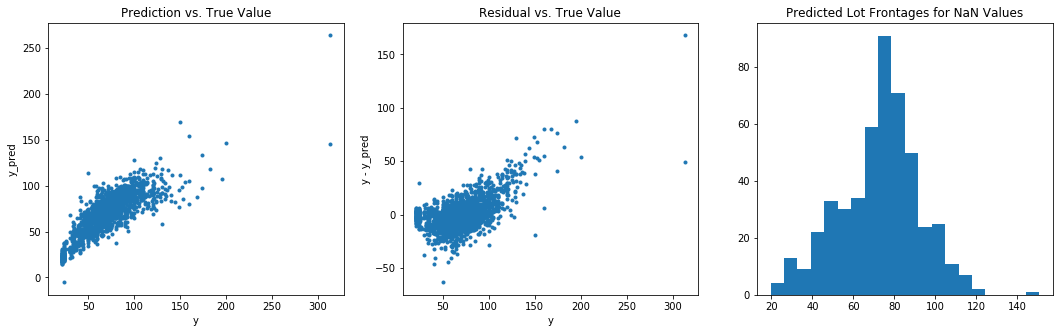

In [6]:
#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

## Remaining NaNs

Now we're just left with a handful of remaining features/properties that have NaN values. All of them happen to be categorical variables, and I just replace the missing values with the mode for that feature. Most of the remaining NaNs are in the test dataset, otherwise I might have just deleted them.

In [7]:
# Remaining Nan values
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]

print(cols_with_na.sort_values(ascending=False))

rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]
print(rows_with_na.sort_values(ascending=False))

# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64
Id
2217    2
2152    2
1916    2
2905    1
2490    1
2474    1
2251    1
1946    1
1556    1
1380    1
dtype: int64


In [8]:
# Now no more NaN values apart from SalePrice in test data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

<a id='bsmtfinish'></a>
## Basement Finish Types

With all the NaN values dealt with, it's time to start investigating and playing with the data to get it in to the format we want for model fitting. Note that the final order things appear in the notebook is not the order I did them at first - a lot of time was spent exploring the data (looking at e.g. the scatter and distribution plots shown later) before I decided on how to fill the NaNs (above), and the feature manipulations below.

In the basement features there are two areas representing a certain finish type, e.g. an area that is converted to "Good living quarters", and an area that is unfinished. The finish type and areas are in separate columns, and a simple model wouldn't catch the interaction between the type and area. So I create new columns representing the area of each finish type the property's basement has, and remove the original columns.

I also realised the area by itself may not be the most useful stat - large properties will have large areas and high sale prices 'by default'. What might be more interesting is the *fraction* of the basement that is of each type. I create more new columns for these fractions.

In the plots below there is a slight positive correlation between the unfinished area and sale price (as larger properties are more likely to have large unfinished areas), but a slight negative correlation between the unfinished *fraction* and the sale price, as having the basement unfinished is undesirable.

BsmtCond BsmtExposure     ...       BsmtLwQFrac  BsmtUnfFrac
Id                           ...                               
1        TA           No     ...               0.0     0.175234
2        TA           Gd     ...               0.0     0.225040
3        TA           Mn     ...               0.0     0.471739
4        Gd           No     ...               0.0     0.714286
5        TA           Av     ...               0.0     0.427948

[5 rows x 18 columns]

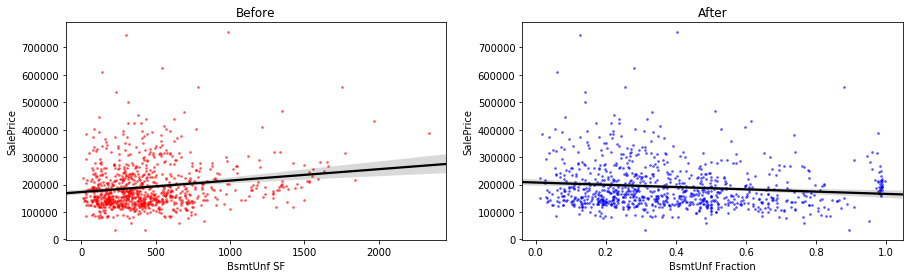

In [9]:
# create separate columns for area of each possible
# basement finish type
bsmt_fin_cols = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
                 'BsmtRec','BsmtLwQ']

for col in bsmt_fin_cols:
    # initialise as columns of zeros
    df_all[col+'SF'] = 0

# fill remaining finish type columns
for row in df_all.index:
    fin1 = df_all.loc[row,'BsmtFinType1']
    if (fin1!='None') and (fin1!='Unf'):
        # add area (SF) to appropriate column
        df_all.loc[row,'Bsmt'+fin1+'SF'] += df_all.loc[row,'BsmtFinSF1']
        
    fin2 = df_all.loc[row,'BsmtFinType2']
    if (fin2!='None') and (fin2!='Unf'):
        df_all.loc[row,'Bsmt'+fin2+'SF'] += df_all.loc[row,'BsmtFinSF2']


# remove initial BsmtFin columns
df_all.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2'], axis=1, inplace=True)

# already have BsmtUnf column in dataset
bsmt_fin_cols.append('BsmtUnf')

# also create features representing the fraction of the basement that is each finish type
for col in bsmt_fin_cols:
    df_all[col+'Frac'] = df_all[col+'SF']/df_all['TotalBsmtSF']
    # replace any nans with zero (for properties without a basement)
    df_all[col+'Frac'].fillna(0,inplace=True)

#plot to demonstrate the effect of the new feature
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.regplot(df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'BsmtUnfSF'],
            df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'SalePrice'],
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'r'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf SF')
plt.title('Before')

plt.subplot(1,2,2)
sns.regplot(df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'BsmtUnfFrac'],
            df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'SalePrice'],            
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'b'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf Fraction')
plt.title('After')


df_all.loc[:,df_all.columns.str.contains('Bsmt')].head(5)

<a id='1st2ndflr'></a>
## 1st and 2nd Floor Area

Like the basement, I thought the fraction of each property's area that is on the 1st floor, 2nd floor, or unfinished may be useful, so I create columns for these.

I also create columns to indicate the total size of the property - TotalAreaSF for the total size of all interior areas, LivingAreaSF for the total area of living quarters (including any in the basement), and StorageAreaSF for total area of non-living quarter interiors (garage etc.)

In [10]:
df_all['LowQualFinFrac'] = df_all['LowQualFinSF']/df_all['GrLivArea']
df_all['1stFlrFrac'] = df_all['1stFlrSF']/df_all['GrLivArea']
df_all['2ndFlrFrac'] = df_all['2ndFlrSF']/df_all['GrLivArea']

df_all['TotalAreaSF'] = df_all['GrLivArea']+df_all['TotalBsmtSF']+df_all['GarageArea']+df_all['EnclosedPorch']+df_all['ScreenPorch']
df_all['LivingAreaSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF'] + df_all['BsmtGLQSF'] + df_all['BsmtALQSF'] + df_all['BsmtBLQSF']
df_all['StorageAreaSF'] = df_all['LowQualFinSF'] + df_all['BsmtRecSF'] + df_all['BsmtLwQSF'] + df_all['BsmtUnfSF'] + df_all['GarageArea']

<a id='categorder'></a>
## Categorical Features with Meaningful Ordering

Some of the categorical variables can directly be converted in to numeric scales. For example, there are many 'quality' features, that have values ranging from "Excellent" to "Poor". These can be converted in to integer scales, with the most desirable descriptions given the highest scores.

In some cases I make an educated guess at what is most desirable, e.g. I assume it is better to have a property that is not on a slope.

In [11]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

display(df_all[cols_ExGd].head(5))    

# Remaining columns
df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)

ExterQual  ExterCond  BsmtQual   ...    GarageQual  GarageCond  PoolQC
Id                                   ...                                  
1           4          3         4   ...             3           3       0
2           3          3         4   ...             3           3       0
3           4          3         4   ...             3           3       0
4           3          3         3   ...             3           3       0
5           4          3         4   ...             3           3       0

[5 rows x 10 columns]

<a id='zeros'></a>
## Dealing with Zeros

All those NaNs I replaced with zeros earlier can actually be a bit of a nuisance. In a linear regression model, the large number of properties with, for example, no 2nd floor, and so zero 2nd floor area, will bias the estimated dependence between sale price and 2nd floor area.

To give the models flexibility to get around this issue, for features with a lot of zeros I add a dummy variable to indicate whether that feature is present in the property or not. The effect of doing this is shown by the plot below. For a couple of features where very few properties have it, I remove the original feature and only keep the dummy variable. I also decided to count the "half bathroom" features literally as 0.5 bathrooms, added them to the "full bathroom" totals, then dropped the "half bathroom" columns.

In [12]:
# fraction of zeros in each column
frac_zeros = ((df_all==0).sum()/len(df_all))

# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

#very few properties with Pool or 3SsnPorch
#replace columns with binary indicator
df_all['HasPool'] = (df_all['PoolQC']>0).astype(int)
df_all['Has3SsnPorch'] = (df_all['3SsnPorch']>0).astype(int)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

# 'half' bathrooms - add half value to 'full' bathrooms
df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

# create additional dummy variable for
# continuous variables with a lot of zeros
dummy_cols = ['LowQualFinSF','2ndFlrSF',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces',             
              'BsmtGLQSF','BsmtALQSF','BsmtBLQSF','BsmtRecSF',
              'BsmtLwQSF','BsmtUnfSF','TotalBsmtSF']

for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

frac_zeros  n_unique  xs_zeros
LowQualFinFrac    0.986297        39  0.960656
LowQualFinSF      0.986297        36  0.958519
3SsnPorch         0.987324        31  0.955066
MiscVal           0.964714        38  0.938398
PoolArea          0.995546        14  0.924118
BsmtLwQFrac       0.917437       225  0.912993
BsmtLwQSF         0.917437       199  0.912412
ScreenPorch       0.912299       121  0.904034
BsmtBLQFrac       0.885235       322  0.882129
BsmtBLQSF         0.885235       283  0.881701
BsmtRecFrac       0.865365       362  0.862602
BsmtRecSF         0.865365       302  0.862054
EnclosedPorch     0.842754       183  0.837290
BsmtALQFrac       0.835218       456  0.833025
BsmtALQSF         0.835218       370  0.832515
PoolQC            0.996574         4  0.746574
BsmtGLQFrac       0.697499       823  0.696284
BsmtGLQSF         0.697499       619  0.695884
BsmtHalfBath      0.940048         3  0.606715
MasVnrArea        0.603289       444  0.601037
2ndFlrFrac        0.571429      1040  0.570467
2ndFlrSF          0.571429       635  0.569854
WoodDeckSF        0.521754       379  0.519116
OpenPorchSF       0.444673       252  0.440705
BsmtFullBath      0.584789         4  0.334789
FireplaceQu       0.486468         6  0.319801
HalfBath          0.628297         3  0.294964
Fireplaces        0.486468         5  0.286468
BsmtUnfFrac       0.082905      1730  0.082327
BsmtUnfSF         0.082905      1135  0.082024
GarageArea        0.054128       603  0.052470
TotalBsmtSF       0.027064      1058  0.026119
StorageAreaSF     0.008565      1397  0.007849

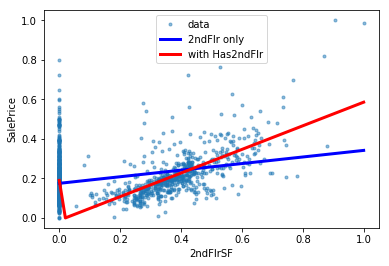

In [13]:
#PROBLEM OF LOTS OF ZEROS EXAMPLE -2ndFlrSF
#####
# mode only using 2ndflrsf
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlrSF','Has2ndFlrSF']].dropna())

y = tmp.SalePrice
X = tmp['2ndFlrSF']

plt.plot(X,y,'.',label='data',alpha=0.5)

lr = LinearRegression()
lr.fit(X.values.reshape(-1, 1),y)
lr_coefs = pd.Series(lr.coef_,index=['Has2ndFlrSF'])
lr_intercept = lr.intercept_

def regval(flr2ndSF):
    return flr2ndSF*lr_coefs + lr_intercept

plt.plot([0,1],[regval(0),regval(1)],'b',linewidth=3,label='2ndFlr only')

#####
# model using has2ndflr dummy variable
#####
tmp = scale_minmax(df_all[['SalePrice','2ndFlrSF','Has2ndFlrSF']].dropna())

y = tmp.SalePrice

X = tmp.drop('SalePrice',axis=1)

lr = LinearRegression()
lr.fit(X,y)
lr_coefs = pd.Series(lr.coef_,index=X.columns)
lr_intercept = lr.intercept_

def regval(flr2ndSF,has2nd):
    return flr2ndSF*lr_coefs['2ndFlrSF'] + has2nd*lr_coefs['Has2ndFlrSF'] + lr_intercept

plt.plot([0,0.02,1],[regval(0,0),regval(0.02,1),regval(1,1)],'r',linewidth=3,label='with Has2ndFlr')

plt.legend()
plt.xlabel('2ndFlrSF')
plt.ylabel('SalePrice');

<a id='transformSP'></a>
## Distribution of SalePrice

Now let's take a look at our most important variable - the sale price. It turns out there is a long tail of outlying properties with high sale prices, which biases the mean to be much higher than the median.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


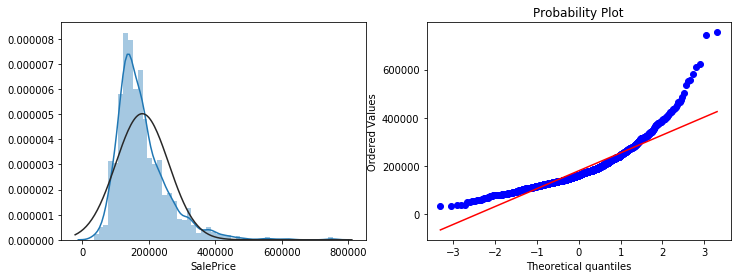

In [14]:
print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(df_all.SalePrice.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(df_all.SalePrice.dropna(), plot=plt)

## Log Transform SalePrice

Many models make assumptions about having normally distributed variables, and the long tail above could hurt the performance of the model fitting later. Log transofrming SalePrice has the double benefit of significantly improving its normality, and being more relevant for the leaderboard evaluation metric (the root-mean-square-error of the log of the predicted sale price). 

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


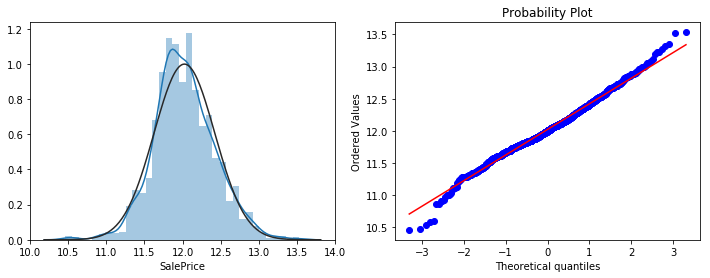

In [15]:
#Log Transform SalePrice to improve normality
sp = df_all.SalePrice
df_all.SalePrice = np.log(sp)

print(df_all.SalePrice.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(sp.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(sp.dropna(), plot=plt)

## Identify Types of Features

Different types of features will need to be treated differently when digging deeper in to the data. Here I identify three types of features:

* **Numeric-discrete:** Numeric features with less than 13 unique values, such as month of the year, or the numeric scales created above.



* **Numeric-continuous:** Numeric features with 13 or more unique values, such as areas, the year a property was built etc.



* **Categorical:** The remaining non-numeric features.

In [16]:
# extract names of numeric columns
dtypes = df_all.dtypes
cols_numeric = dtypes[dtypes != object].index.tolist()

# MSubClass should be treated as categorical
cols_numeric.remove('MSSubClass')

# choose any numeric column with less than 13 values to be
# "discrete". 13 chosen to include months of the year.
# other columns "continuous"
col_nunique = dict()

for col in cols_numeric:
    col_nunique[col] = df_all[col].nunique()
    
col_nunique = pd.Series(col_nunique)

cols_discrete = col_nunique[col_nunique<13].index.tolist()
cols_continuous = col_nunique[col_nunique>=13].index.tolist()

print(len(cols_numeric),'numeric columns, of which',
      len(cols_continuous),'are continuous and',
      len(cols_discrete),'are discrete.')

82 numeric columns, of which 37 are continuous and 45 are discrete.


In [17]:
# extract names of categorical columns
cols_categ = dtypes[~dtypes.index.isin(cols_numeric)].index.tolist()

for col in cols_categ:
    df_all[col] = df_all[col].astype('category')
    
print(len(cols_categ),'categorical columns.')

25 categorical columns.


<a id='distribFeats'></a>
## Distribution of SalePrice in Categorical Variables

Starting with the categorical variables, let's get a better idea of what the data looks like, and which features might be the most important for predicting sale price. Here I make use of seaborn's violinplot function, which nicely shows how the distribution and mean of the sale price changes for different categories within each feature.

At this point it's difficult to say much, other than there are definitely some values that have a large effect on sale price, e.g. properties in commercial zoning areas (`MSZoning == 'C(all)'`) have much lower sale prices on average. But there is also generally a large spread in sale prices within any single feature category value.

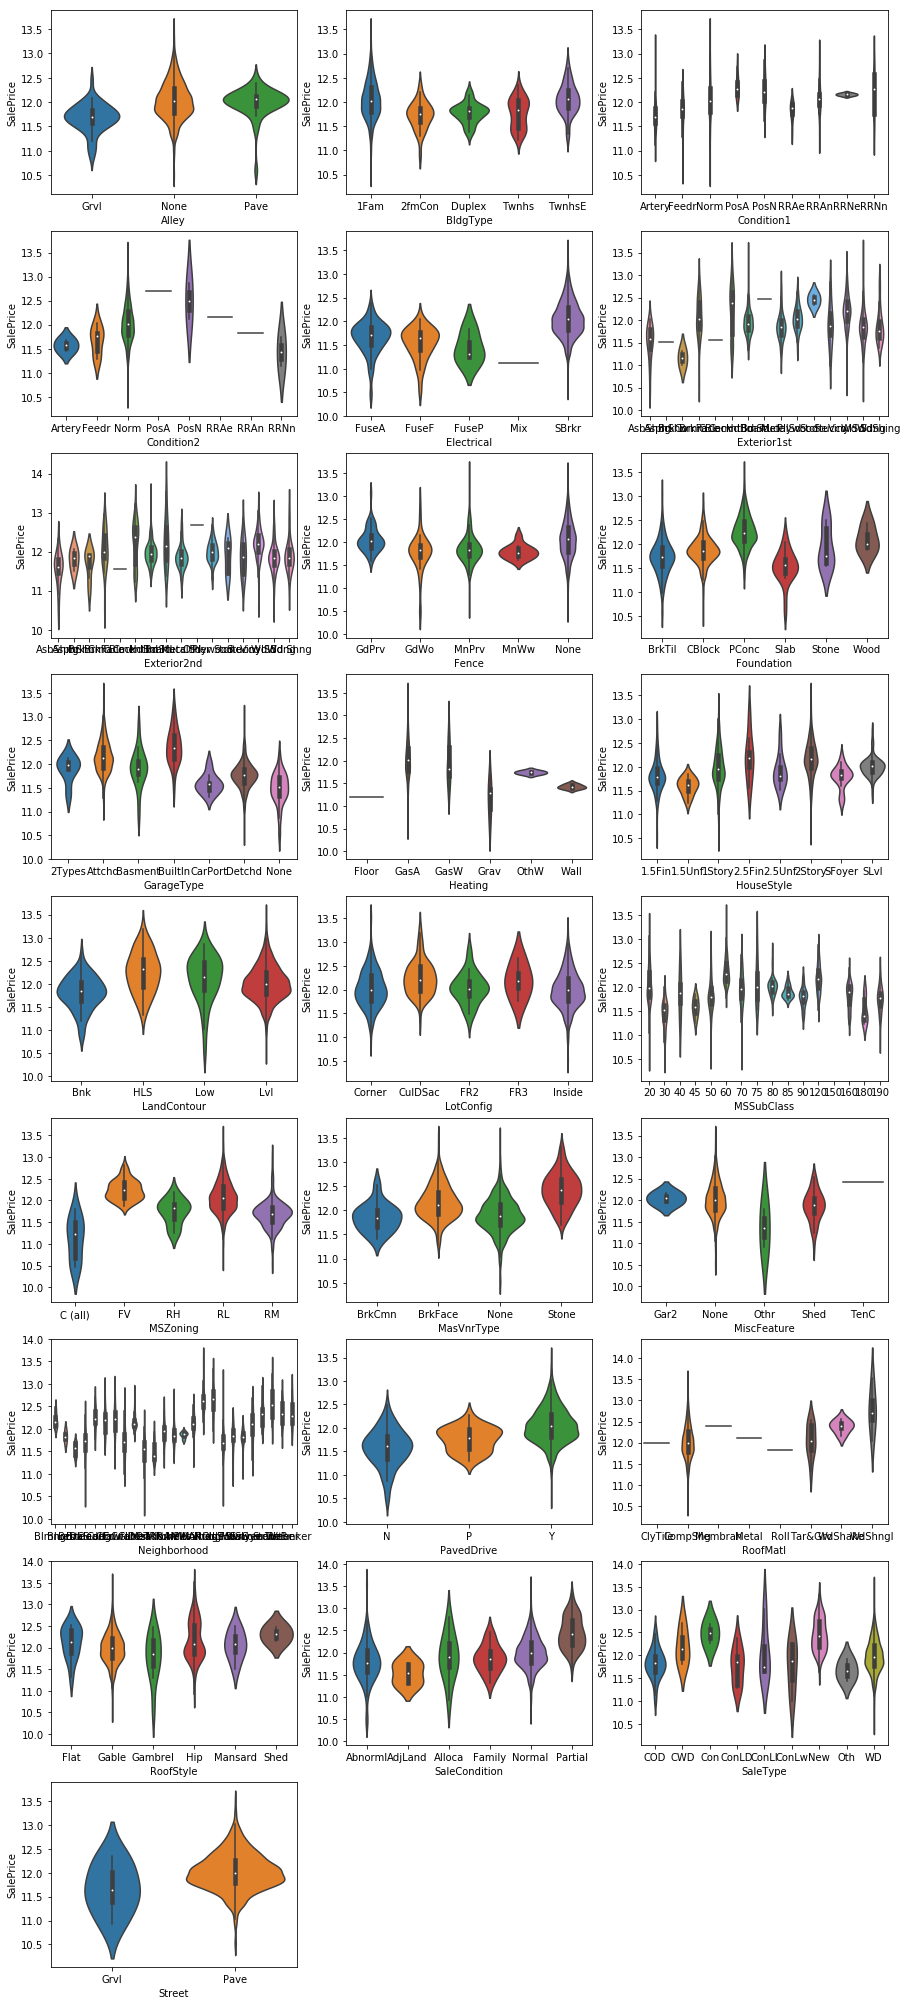

In [18]:
# plot categorical variables
fcols = 3
frows = ceil(len(cols_categ)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_categ):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

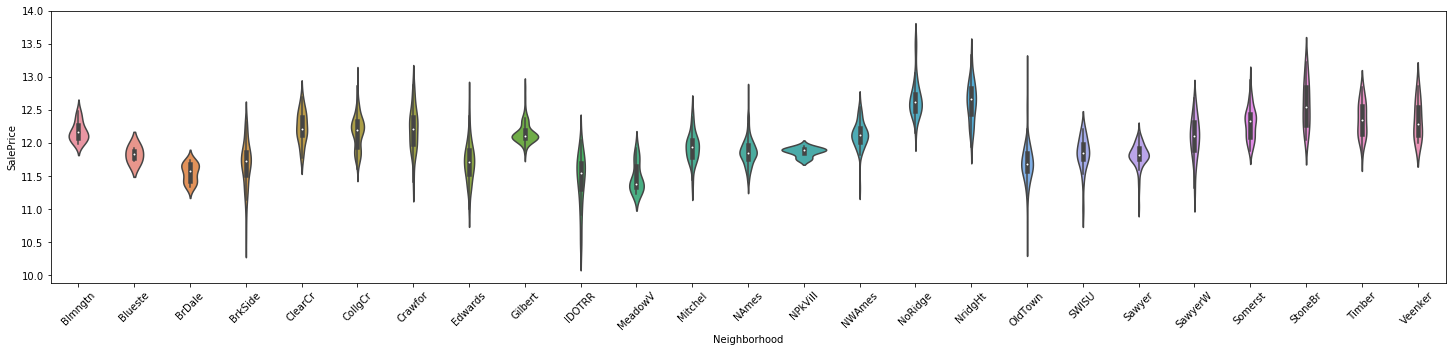

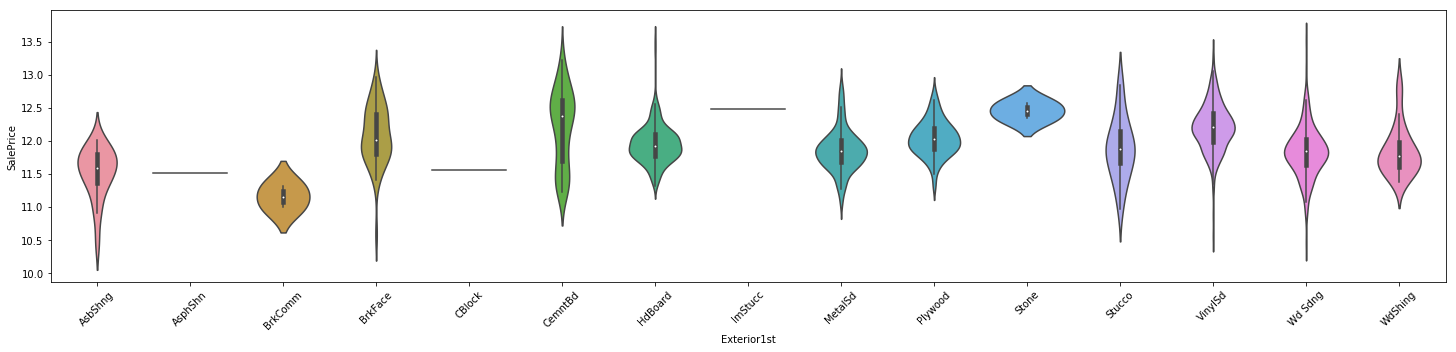

In [19]:
# few bigger plots for features with too many categories to see above

#Neighbourhood
plt.figure(figsize=(25,5))
sns.violinplot(x='Neighborhood',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

#Exterior1st
plt.figure(figsize=(25,5))
sns.violinplot(x='Exterior1st',y='SalePrice',data=df_all)
plt.xticks(rotation=45);

<a id='sigcateg'></a>
## Significance of Categorical Features for SalePrice

To get a better idea of the importance of each categorical variable for sale price prediction I perform an ANOVA test. I wrote my own function here (apart from obtaining the p-value at the end), as a learning exercise. You could do it directly with `scipy.stats.f_oneway` I believe.

Almost all the categorical features show a significant effect on sale price, with Neighborhood, Garage Type, MSubClass (type of dwelling) and Foudation apparently the most important.

In [20]:
# anova test to check significance of variation in column 'group' vs. column 'value' 
def anova(group,value):
    # select columns of interest, and remove any rows with nan values
    data = df_all[[group,value]]
    data = data[~(data[group].isnull() | data[value].isnull())]
    
    # stats across all data
    tot_groups = data[group].nunique() # no. of groups
    len_data = len(data) # total sample size of houses (all groups)
    mean_data = data[value].mean() # mean across all groups
    df_betwn = tot_groups - 1 # degrees of freedom betwn grps
    df_within = len_data - tot_groups # degrees of freedom within grps
    
    # per group stats
    n_in_group = data.groupby(group)[value].count() # no. houses in group
    mean_group = data.groupby(group)[value].mean() # mean value in this group
    
    # between-group variability
    betwn_var = n_in_group*((mean_group - mean_data)**2)
    betwn_var = float(betwn_var.sum())/df_betwn
    
    # within-group variability
    within_var = 0
    for grp in data[group].unique():
        samples = data.loc[data[group]==grp, value]
        within_var += ((samples-mean_group[grp])**2).sum()
        
    within_var = float(within_var)/df_within
    
    #F-test statistic
    F = betwn_var/within_var
    
    # p-value
    p = stats.f.sf(F, df_betwn, df_within)
    
    return p      

In [21]:
# check significance of categorical variables on SalePrice
p_col = dict()

for col in cols_categ:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

Neighborhood     4.043304e-243
GarageType       8.427845e-125
MSSubClass       5.096023e-115
Foundation       1.350671e-111
MasVnrType        1.670061e-65
MSZoning          1.021343e-59
Exterior1st       1.053128e-53
Exterior2nd       2.429938e-49
SaleCondition     1.689708e-41
SaleType          5.497893e-36
PavedDrive        1.090995e-31
Electrical        6.081144e-31
HouseStyle        1.636077e-30
Fence             6.560319e-13
RoofStyle         1.705740e-12
BldgType          3.436794e-12
Condition1        1.173444e-10
Alley             1.358108e-09
Heating           2.484312e-09
LandContour       3.086224e-08
LotConfig         6.214575e-07
RoofMatl          4.504239e-04
MiscFeature       6.059928e-03
Condition2        1.382042e-02
Street            2.837931e-02
dtype: float64

## Distribution of SalePrice in Discrete Numeric Features

Now let's repeat the same process for the discrete numeric features. In this case some relationships are obvious, e.g. the sale price is strongly dependent on the overall quality (`OverallQual`) of a property. Alternatively, the month of sale seems to have no effect.

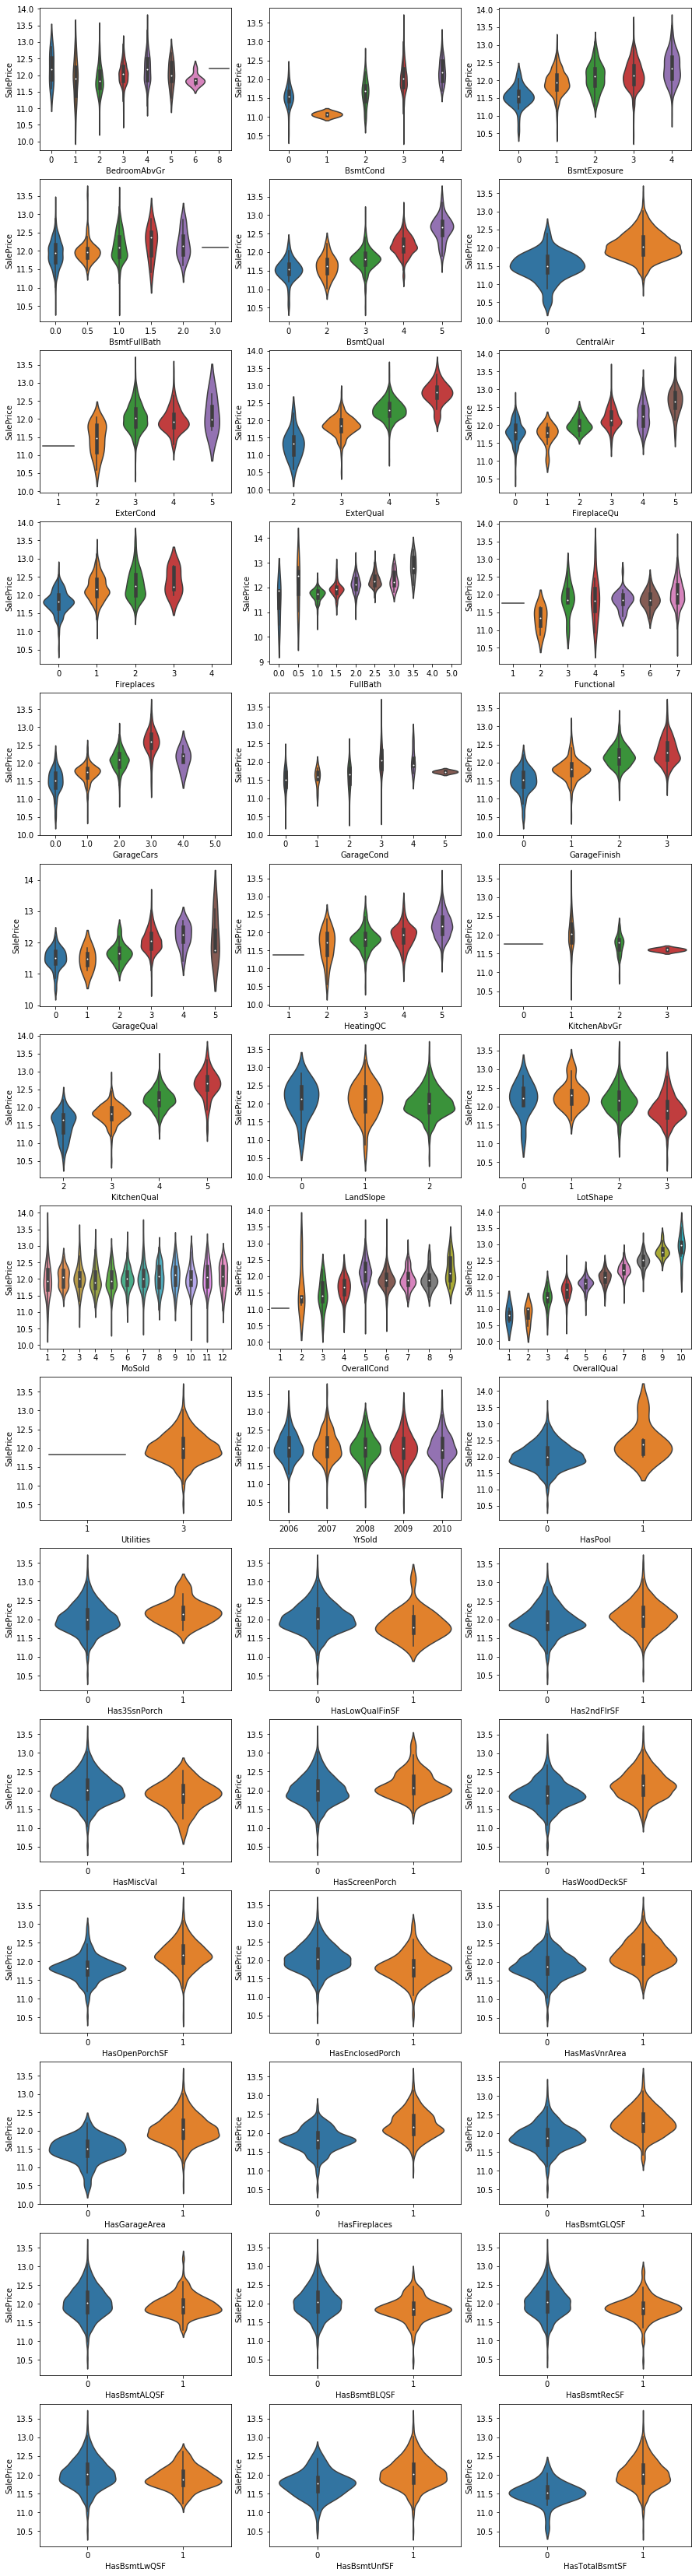

In [22]:
# figure parameters
fcols = 3
frows = ceil(len(cols_discrete)/fcols)
plt.figure(figsize=(15,4*frows))

for i,col in enumerate(cols_discrete):
    plt.subplot(frows,fcols,i+1)
    sns.violinplot(df_all[col],df_all['SalePrice'])

<a id='sigdiscrete'></a>
## Significance of Discrete Numeric Features for SalePrice

Performing ANOVA tests on the discrete variables gives sensible results based on what's observed above. The dependence on overall quality is so strong it registers a p-value of zero!

In [23]:
p_col = dict()

for col in cols_discrete:
    p_col[col] = anova(col,'SalePrice')
    
pd.Series(p_col).sort_values()

OverallQual          0.000000e+00
GarageCars          5.539585e-211
ExterQual           6.935425e-195
BsmtQual            2.031282e-188
KitchenQual         4.441486e-187
FullBath            3.733271e-167
GarageFinish        4.057458e-151
FireplaceQu         6.963458e-115
HasFireplaces        1.688600e-97
Fireplaces           7.485912e-97
HeatingQC            1.614882e-82
HasOpenPorchSF       2.024867e-73
HasBsmtGLQSF         3.828370e-69
OverallCond          9.270535e-53
HasMasVnrArea        5.246135e-52
GarageCond           2.508058e-47
BsmtExposure         2.590707e-47
GarageQual           6.068406e-46
CentralAir           9.855628e-44
HasGarageArea        8.411473e-37
HasWoodDeckSF        3.391236e-36
LotShape             7.856968e-29
BsmtCond             1.492754e-27
BedroomAbvGr         2.473588e-20
BsmtFullBath         2.301539e-17
HasEnclosedPorch     5.905933e-17
HasTotalBsmtSF       1.370151e-14
ExterCond            6.540305e-14
HasBsmtUnfSF         1.603646e-13
Has2ndFlrSF   

## Distribution of Continuous Variables and Effect on SalePrice

Finally - the continuous variables. For these I revert back to scatter plots and standard histograms. Some strong relationships are immediately clear - for example between the `TotalAreaSF` feature created earlier and the sale price. The nuisance caused by zeros and/or outliers can again be seen by the poor quality regression lines in LotArea, for example.

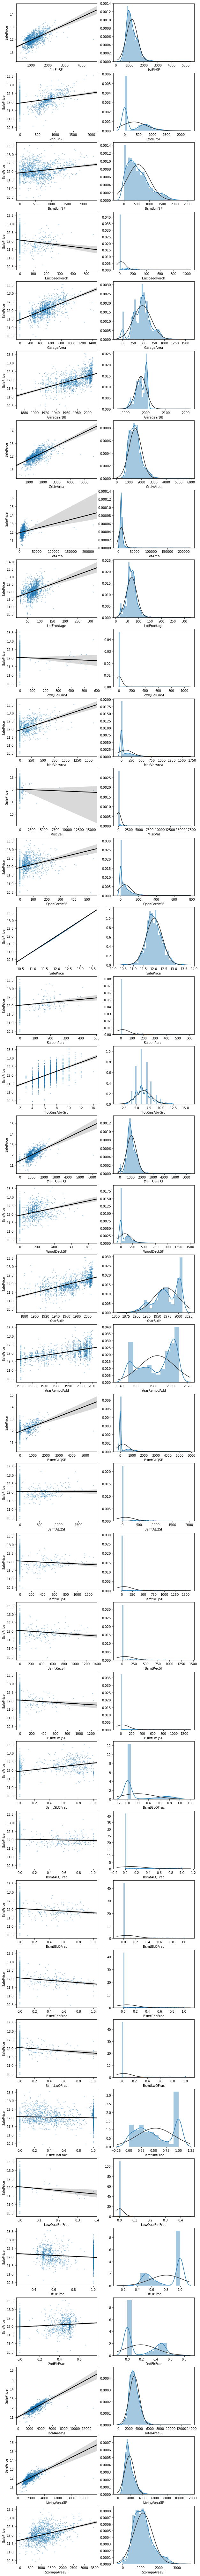

In [24]:
# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='SalePrice', data=df_all, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df_all[col].dropna() , fit=stats.norm)
    plt.xlabel(col)

<a id='correl'></a>
## Correlation Between Numeric Features

For all the numeric features (discrete and continuous) let's check the correlation with sale price. I've used the Spearman correlation coefficient, which is more resilient to identifying non-linear relationships than Pearson. I also consider only the absolute value of the coefficient, as I'm interested in finding the strongest relationships, not whether they are positively/negatively correlated.

The most correlated features relate to the overall size and quality of the house. Having a garage also seems important, as well as the age of the property. The least correlated features tend to be those that appear in very few or almost all properties - for example nearly all houses have the full range of utilities, but very few have a pool. It's more surprising that the condition of a house does not seem very important for sale price - the distinction between that and the quality of a hosue isn't particularly clear to me.

SalePrice        1.000000
TotalAreaSF      0.834994
OverallQual      0.809829
LivingAreaSF     0.753706
GrLivArea        0.731310
GarageCars       0.690711
ExterQual        0.684014
BsmtQual         0.678026
FullBath         0.675455
KitchenQual      0.672849
YearBuilt        0.652682
GarageArea       0.649379
GarageFinish     0.633974
GarageYrBlt      0.612604
TotalBsmtSF      0.602725
1stFlrSF         0.575408
YearRemodAdd     0.571159
FireplaceQu      0.537602
TotRmsAbvGrd     0.532586
HasFireplaces    0.525735
Name: SalePrice, dtype: float64
-----------------
Has3SsnPorch    0.065329
HasMiscVal      0.063389
MiscVal         0.062727
BsmtALQSF       0.061374
HasPool         0.058428
LandSlope       0.050310
BsmtUnfFrac     0.036628
YrSold          0.029899
Utilities       0.016710
ExterCond       0.011682
Name: SalePrice, dtype: float64


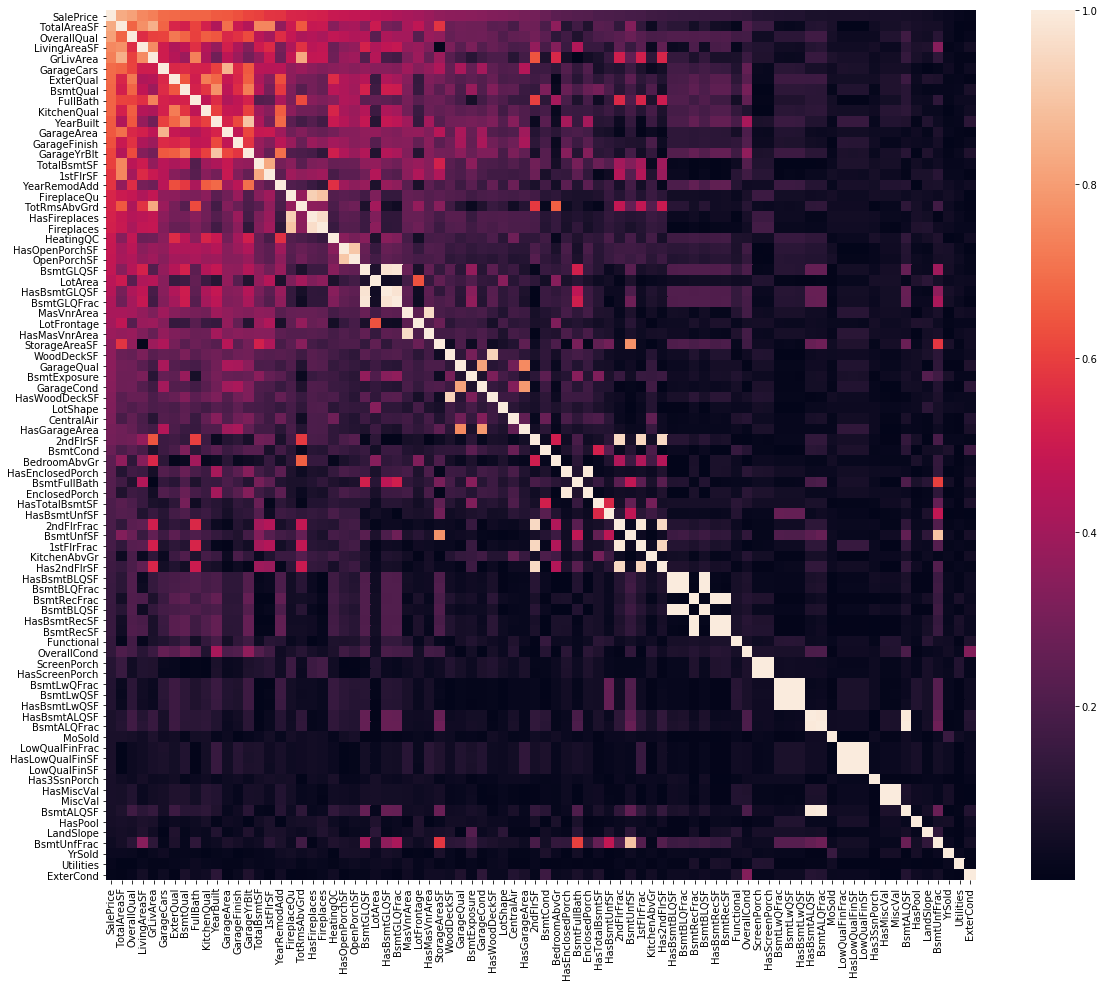

In [25]:
# correlation between numeric variables
df_corr = df_all.loc[id_train, cols_numeric].corr(method='spearman').abs()

# order columns and rows by correlation with SalePrice
df_corr = df_corr.sort_values('SalePrice',axis=0,ascending=False).sort_values('SalePrice',axis=1,ascending=False)

print(df_corr.SalePrice.head(20))
print('-----------------')
print(df_corr.SalePrice.tail(10))

ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(df_corr,ax=ax,square=True)

## Collinearity

As can be seen in the heatmap above, many of the features are correlated with each other. Some of these are clear - for example the area of a garage and the number of cars it can hold are clearly related. This relationship is plotted below, although the distinction maybe isn't as clear as expected - there is a garage with capacity for 1 car that has an area bigger than many of the garages with capacity for 4 cars, for example.

A lot of the features I created earlier, such as the dummy variables that indicate whether a feature is present or not, are natrually highly correlated with the features they represent.

Having collinear features can make it more difficult for our models to identify which parameters are truly important. Some of the features, like garage area, provide very little extra information and probably could be removed.  However, I have taken a lazy approach, kept all the features, and relied on the models to do a decent enough job at picking out which features to use.

But this is definitely something that could be looked at to improve, and removing some features may help some of the more complicated models get better results.

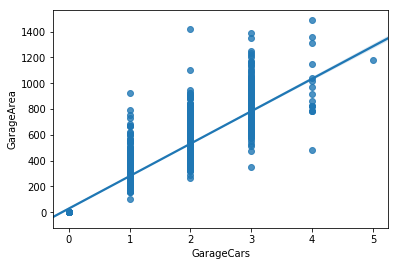

In [26]:
sns.regplot(x='GarageCars',y='GarageArea',data=df_all)

## Normalise Numeric Features

As we have features with very different scales (such as areas and counts), I normalise all the numeric features using a simple function I defined earlier (in the LotFrontage NaN values section - though again there are built-in functions in sklearn etc. that could do this) to lie between zero and one. This helps to prevent the model from being biased towards using certain features.

In [27]:
# normalise numeric columns
scale_cols = [col for col in cols_numeric if col!='SalePrice']

df_all[scale_cols] = df_all[scale_cols].apply(scale_minmax,axis=0)

df_all[scale_cols].describe()

1stFlrSF     2ndFlrSF       ...        HasBsmtUnfSF  HasTotalBsmtSF
count  2919.000000  2919.000000       ...         2919.000000     2919.000000
mean      0.173405     0.162946       ...            0.917095        0.972936
std       0.082412     0.207604       ...            0.275786        0.162298
min       0.000000     0.000000       ...            0.000000        0.000000
25%       0.113842     0.000000       ...            1.000000        1.000000
50%       0.157110     0.000000       ...            1.000000        1.000000
75%       0.221277     0.340920       ...            1.000000        1.000000
max       1.000000     1.000000       ...            1.000000        1.000000

[8 rows x 81 columns]

<a id='transformFeats'></a>
## Which Numeric Features are Candidates to be Transformed?

Like I did for `SalePrice`, we can transform the continuous numeric features to try to improve their normality. For `SalePrice` I used a simple log transform, but here I try the more flexible Box-Cox transform, letting the `scipy.stats.boxcox` function optimise the parameters of the fit in each case.

Here I plot the original and transformed distributions for all the continuous features to identify which transformations look reasonable.

NB - I did try using BoxCox on `SalePrice` too, but it gives no improvement or is slightly worse than log transform. So I kept the log transform for `SalePrice` as it's easier to revert it in to the original dollar values.


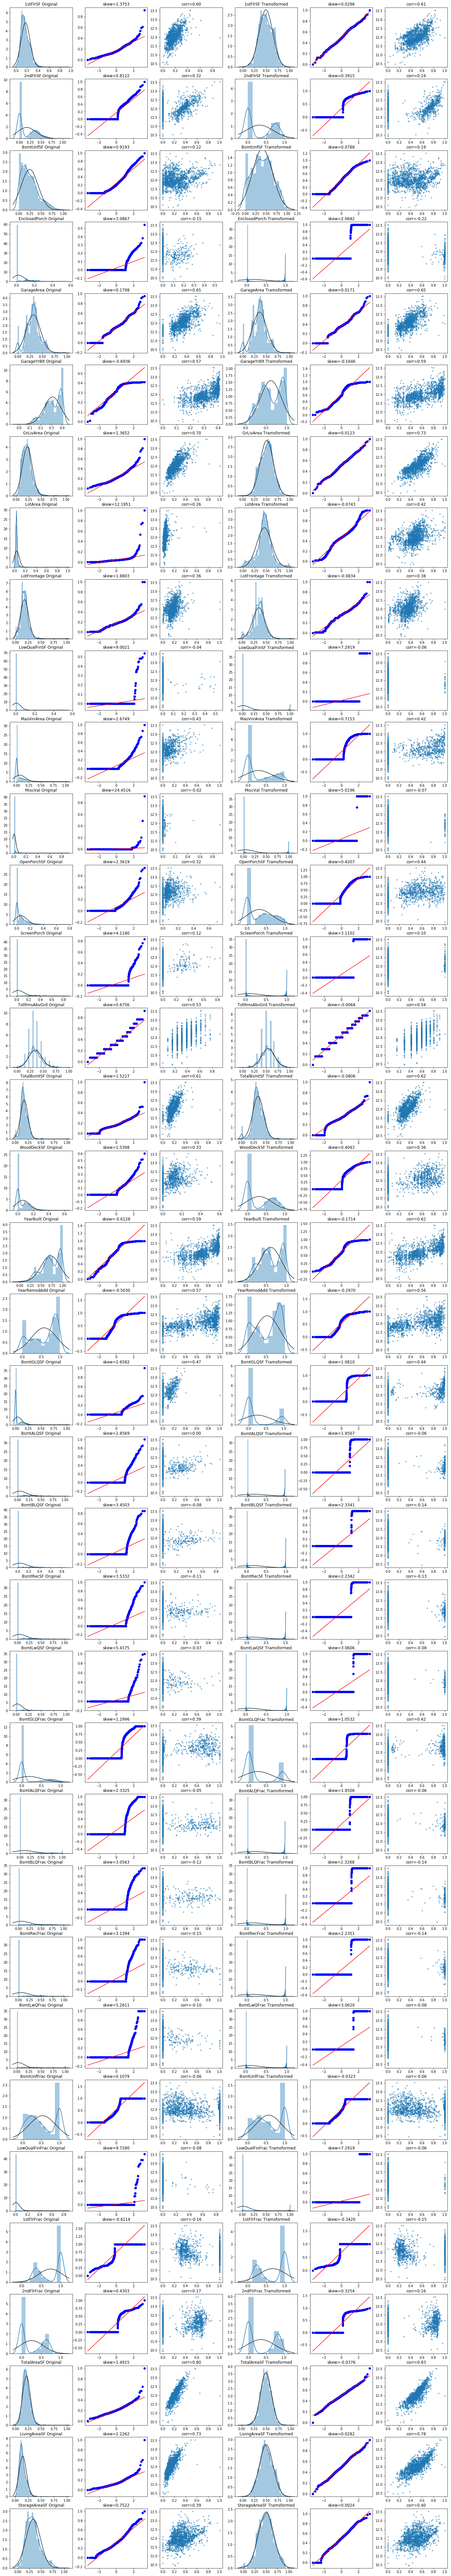

In [28]:
#Check effect of Box-Cox transforms on distributions of continuous variables
fcols = 6
frows = len(cols_continuous)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='SalePrice':
        dat = df_all[[var, 'SalePrice']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['SalePrice'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['SalePrice'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['SalePrice'])[0][1]))

## Box-Cox Transform Suitable Variables

The transformation doesn't help, and in some cases degrades, some of the variables, usually because of those pesky zeros again. For example, `2ndFlrSF` has many zeros for properties that don't have a second floor. The transformation in this case doesn't achieve much other than separating the zero and non-zero points by a greater margin.

By inspecting all the plots above I define a list of features for which the transform doesn't help. I transform and then re-normalise the remaining features.

In [29]:
# variables not suitable for box-cox transformation based on above (usually due to excessive zeros)
cols_notransform = ['2ndFlrSF','1stFlrFrac','2ndFlrFrac','StorageAreaSF',
                    'EnclosedPorch','LowQualFinSF','MasVnrArea',
                    'MiscVal','ScreenPorch','OpenPorchSF','WoodDeckSF','SalePrice',
                    'BsmtGLQSF','BsmtALQSF','BsmtBLQSF','BsmtRecSF','BsmtLwQSF','BsmtUnfSF',
                    'BsmtGLQFrac','BsmtALQFrac','BsmtBLQFrac','BsmtRecFrac','BsmtLwQFrac','BsmtUnfFrac']

cols_transform = [col for col in cols_continuous if col not in cols_notransform]

#transform remaining variables
print('Transforming',len(cols_transform),'columns:',cols_transform)

for col in cols_transform:   
    # transform column
    df_all.loc[:,col], _ = stats.boxcox(df_all.loc[:,col]+1)
    
    # renormalise column
    df_all.loc[:,col] = scale_minmax(df_all.loc[:,col])

Transforming 13 columns: ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'LowQualFinFrac', 'TotalAreaSF', 'LivingAreaSF']


<a id='dummies'></a>
## Prepare Data for Model Fitting

Almost time to start fitting some models, all that's left to do is to figure out what to do with the remaining categorical features. I decided to use one-hot encoding (creating a binary indicator for each possible feature value), which is very easy to obtain with the `pandas.DataFrame.get_dummies` function. This ends up increasing the number of variables in the dataset from about 100 to around 250.

I did briefly try other methods, such as label encoding, but they seemed to give worse results. However, I suspect that approach might be more useful when adding feature interactions (see below).

In [30]:
# select features, encode categoricals, create dataframe for model fitting

# select which features to use (all for now)
model_cols = df_all.columns

# encode categoricals
df_model = pd.get_dummies(df_all[model_cols])

# Rather than including Condition1 and Condition2, or Exterior1st and Exterior2nd,
# combine the dummy variables (allowing 2 true values per property)
if ('Condition1' in model_cols) and ('Condition2' in model_cols):
    
    cond_suffix = ['Artery','Feedr','Norm','PosA','PosN','RRAe','RRAn','RRNn']
    
    for suffix in cond_suffix:
        col_cond1 = 'Condition1_'+suffix
        col_cond2 = 'Condition2_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
if ('Exterior1st' in model_cols) and ('Exterior2nd' in model_cols):
    
    # some different strings in Exterior1st and Exterior2nd for same type - rename columns to correct
    df_model.rename(columns={'Exterior2nd_Wd Shng':'Exterior2nd_WdShing',
                             'Exterior2nd_Brk Cmn':'Exterior2nd_BrkComm',
                             'Exterior2nd_CmentBd':'Exterior2nd_CemntBd'},inplace=True)

    ext_suffix = ['AsphShn','BrkComm','BrkFace','CBlock','CemntBd',
                    'HdBoard','ImStucc','MetalSd','Plywood','Stone',
                    'Stucco','VinylSd','Wd Sdng','WdShing','AsbShng']
    
    for suffix in ext_suffix:
        col_cond1 = 'Exterior1st_'+suffix
        col_cond2 = 'Exterior2nd_'+suffix
        
        df_model[col_cond1] = df_model[col_cond1] | df_model[col_cond2]
        df_model.drop(col_cond2,axis=1,inplace=True)
        
display(df_model.head())

1stFlrSF  2ndFlrSF     ...       Street_Grvl  Street_Pave
Id                         ...                               
1   0.362867  0.413559     ...                 0            1
2   0.543162  0.000000     ...                 0            1
3   0.395939  0.419370     ...                 0            1
4   0.416107  0.366102     ...                 0            1
5   0.497820  0.509927     ...                 0            1

[5 rows x 250 columns]

In [31]:
# function to get training samples
def get_training_data():
    # extract training samples
    df_train = df_model.loc[id_train]
    
    # split SalePrice and features
    y = df_train.SalePrice
    X = df_train.drop('SalePrice',axis=1)
    
    return X, y

# extract test data (without SalePrice)
def get_test_data():
    return df_model.loc[id_test].drop('SalePrice',axis=1)

<a id='outliers'></a>
## Identify and Remove Outliers

Now time to start fitting some models! First I fit a linear regression Ridge model, because it immediately gives good results with default values. My goal here is to use a straightforward model to identify any outlying points - properties with sale prices far away from what's expected given their features.

The function I define below fits the model and checks the residuals between the model's predicted sale prices and the true sale prices. The standard deviation of the residuals is calculated, and the 20 or so properties with residuals greater than three times this standard deviation are removed from the training data so they don't skew the parameters of the fitted models.

Just Ridge with default values already gives a decent prediction, which is a promising sign.

In [32]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [33]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.938239438034
rmse= 0.0992364670224
---------------------------------------
mean of residuals: -7.555599981284627e-16
std of residuals: 0.09927046958188981
---------------------------------------
20 outliers:
[31, 89, 411, 463, 496, 524, 589, 629, 633, 682, 729, 875, 899, 969, 971, 1183, 1299, 1325, 1433, 1454]


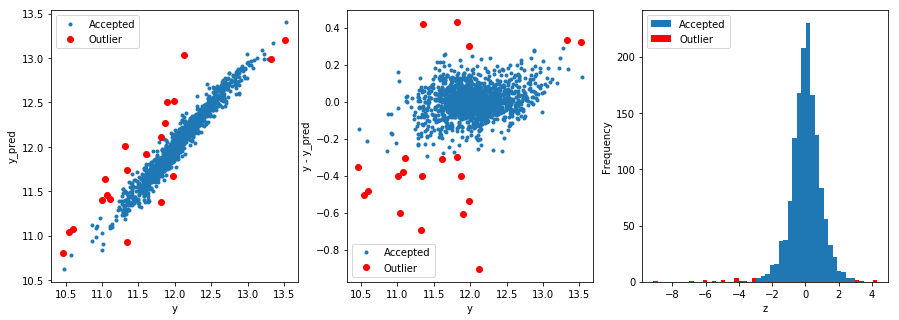

In [34]:
# get training data
X, y = get_training_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X, y)

# permanently remove these outliers from the data
df_model = df_model.drop(outliers)
id_train = id_train.drop(outliers)

<a id='modelfit'></a>
## Fit and Optimise Models

To avoid repeating code I create a function to perform the fitting process for each model type I try. I use k-fold cross-validation to reduce the chances of overfitting the training data - specifically 5-fold cross-validation repeated 5 times (another choice mainly to try another function I hadn't used before - `sklearn.model_selection.RepeatedKFold`). The parameters of each model are optimised using a grid search, and the function returns the best model found and some stats on the model performance.

The models I optimise are:

**Linear Regression:**
* `sklearn.linear_model.Ridge`
* `sklearn.linear_model.Lasso`
* `sklearn.linear_model.ElasticNet`

**Support Vector Machines:**
* `sklearn.svm.LinearSVR`
* `sklearn.svm.SVR`

**Nearest Neighbours:**
* `sklearn.neighbors.KNearestNeighborsRegressor`

**Tree Based:**
* `sklearn.ensemble.RandomForestRegressor`
* `sklearn.ensemble.GradientBoostingRegressor`
* `xgboost.XGBRegressor`

There is some trial and error involved in finding the right parameter ranges to search for each model. The current ranges in the notebook contain the optimal values I found whilst being restictive enough to compute within a few minutes on my measly laptop.

In [35]:
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_training_data()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [36]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

## Linear Regression

### Ridge

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    5.8s finished


----------------------
Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
----------------------
score= 0.959053462871
rmse= 0.0784897773498
cross_val: mean= 0.0946757977727 , std= 0.00365162605562


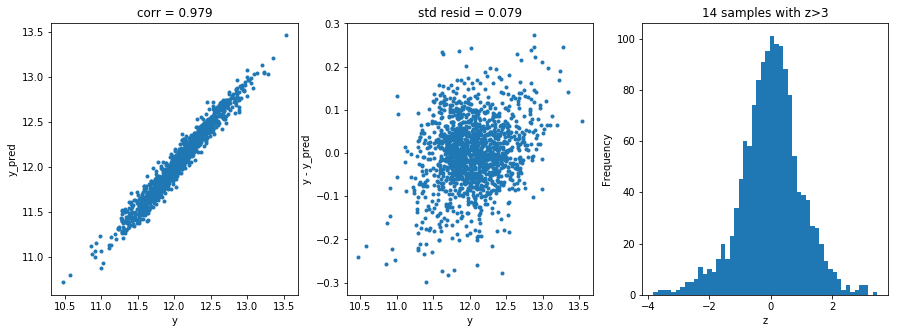

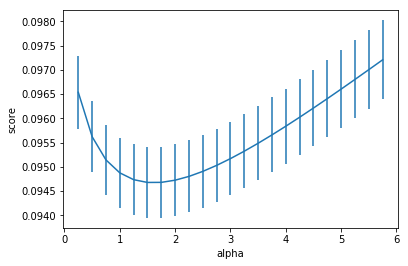

In [37]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### Lasso

Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:   26.4s finished


----------------------
Lasso(alpha=0.00022000000000000003, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.955755456062
rmse= 0.0815895182838
cross_val: mean= 0.0918879819029 , std= 0.00289964235206


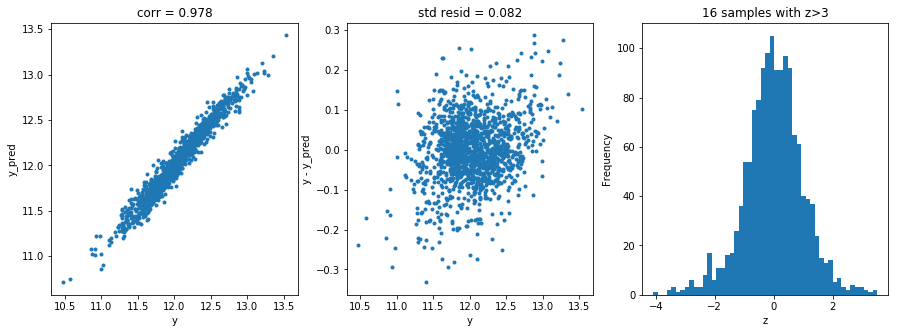

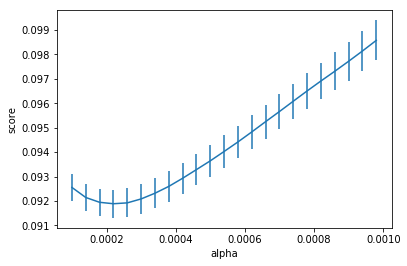

In [38]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score');

### ElasticNet

Fitting 25 folds for each of 81 candidates, totalling 2025 fits


[Parallel(n_jobs=1)]: Done 2025 out of 2025 | elapsed:  2.2min finished


----------------------
ElasticNet(alpha=0.00030000000000000003, copy_X=True, fit_intercept=True,
      l1_ratio=0.80000000000000004, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.955282510774
rmse= 0.0820244284875
cross_val: mean= 0.0923143663231 , std= 0.0037720204772


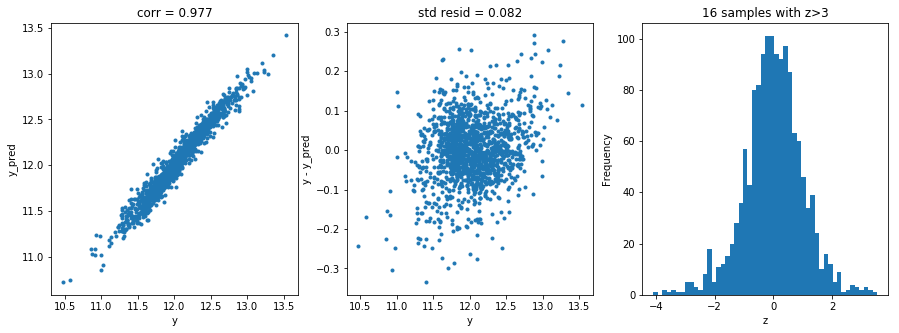

In [39]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

## SVM

### Linear

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:  5.8min finished


----------------------
LinearSVR(C=0.90000000000000002, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100000,
     random_state=None, tol=0.0001, verbose=0)
----------------------
score= 0.956064256845
rmse= 0.0813042964195
cross_val: mean= 0.10528868031 , std= 0.00834010405496


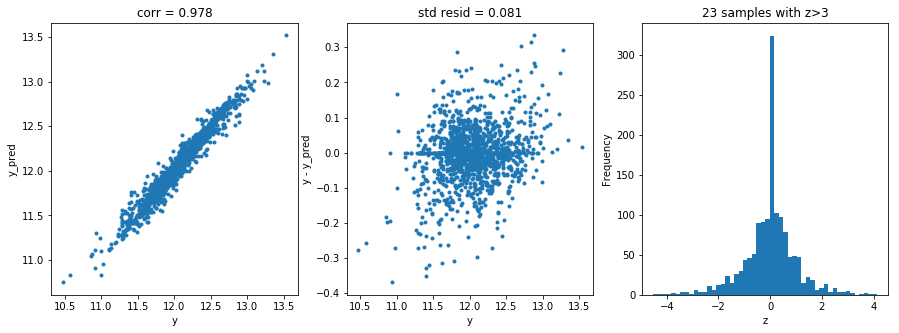

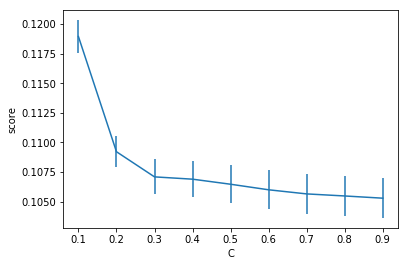

In [40]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score');

### Non-Linear

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.0min finished


----------------------
SVR(C=13, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
----------------------
score= 0.96425897493
rmse= 0.0733310679135
cross_val: mean= 0.0984425652541 , std= 0.00760868100812


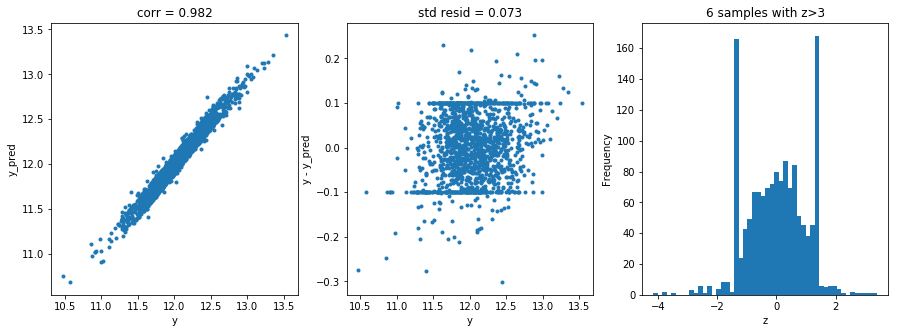

In [41]:
model ='SVR'
opt_models[model] = SVR()

param_grid = {'C':np.arange(1,21,2),
              'kernel':['poly','rbf','sigmoid'],
              'gamma':['auto']}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

## KNeighbors

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   38.2s finished


----------------------
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform')
----------------------
score= 0.852068225816
rmse= 0.14918846328
cross_val: mean= 0.179482808113 , std= 0.0129804206118


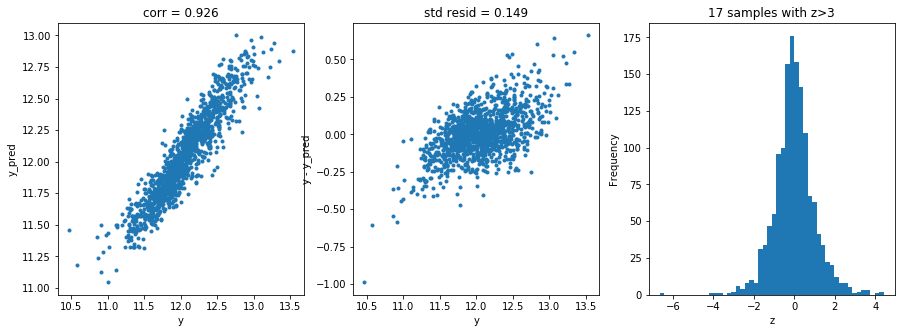

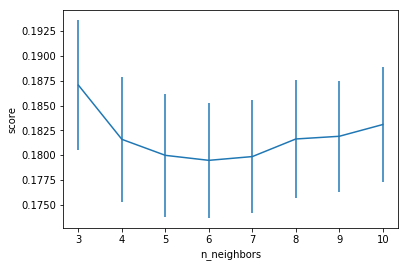

In [42]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score');

## Tree-Based

### Random Forest

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.6min finished


----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=50, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
----------------------
score= 0.987355399748
rmse= 0.0436171273804
cross_val: mean= 0.117303374375 , std= 0.00726948483765


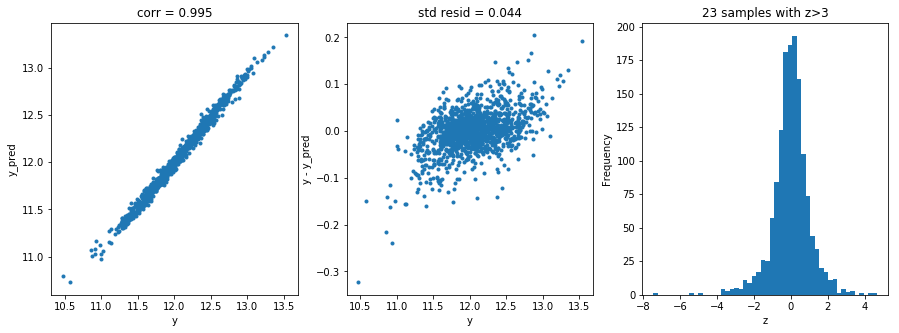

In [43]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[25,50,75],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

### Gradient Boosting

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.4min finished


----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=7, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
----------------------
score= 0.972541149193
rmse= 0.0642755329397
cross_val: mean= 0.102663552886 , std= 0.00615888046309


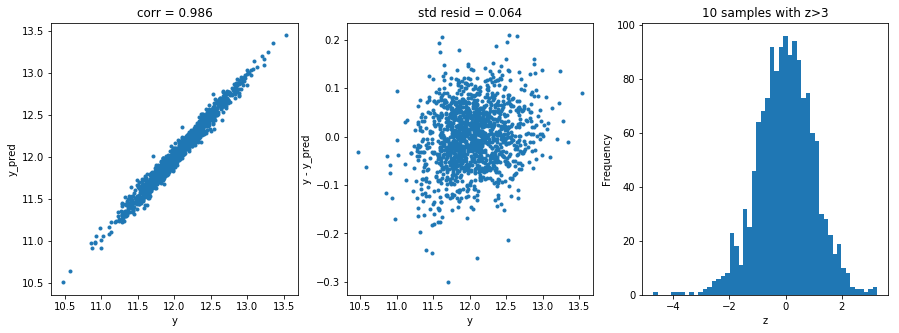

In [44]:
model = 'GradientBoosting'
opt_models[model] = GradientBoostingRegressor()

param_grid = {'n_estimators':[150,250,350],
              'max_depth':[1,2,3],
              'min_samples_split':[5,6,7]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

### XGBoost

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.3min finished


----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------
score= 0.98764146251
rmse= 0.0431209228934
cross_val: mean= 0.0995342484432 , std= 0.00911604296323


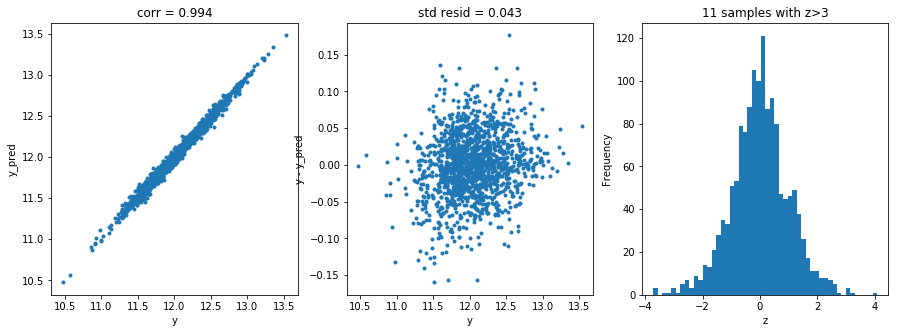

In [45]:
model = 'XGB'
opt_models[model] = XGBRegressor()

param_grid = {'n_estimators':[100,200,300,400,500],
              'max_depth':[1,2,3],
             }

opt_models[model], cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

## Compare Models

Roughly speaking the linear regression models perform best, then support vector machines, then the tree-based ensembles and KNeighbors brings up the rear. The worst performing models, `KNeighbors` and `RandomForest`, have some correlation between the residuals and the sale price, which indicates there are relationships in the features those models haven't been able to identify as well as the others.

Most of the features in the data have a close to linear relationship with sale price (at least the most important ones), so maybe it's not so surprising to see linear regression on top, even if they are the simplest, most restrictive models. The feature engineering I did was also with the limitations of linear regression in mind. However, I have seen in other people's notebooks that `XGBoost` tends to be better than, or at least similar to, the linear models. I don't have an explanation for why that isn't the case for me. 

mean       std
Lasso             0.091888  0.002900
ElasticNet        0.092314  0.003772
Ridge             0.094676  0.003652
SVR               0.098443  0.007609
XGB               0.099534  0.009116
GradientBoosting  0.102664  0.006159
LinearSVR         0.105289  0.008340
RandomForest      0.117303  0.007269
KNeighbors        0.179483  0.012980

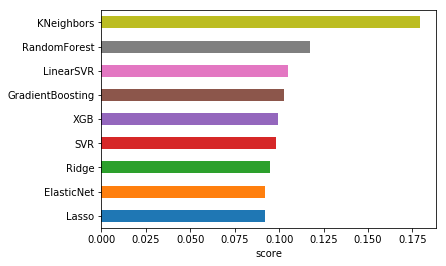

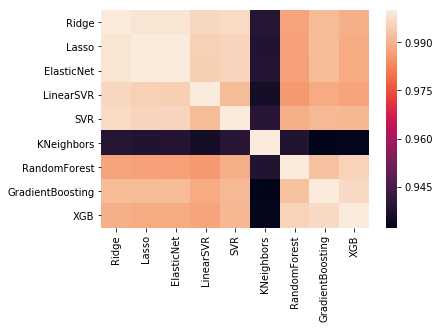

In [46]:
X,y = get_training_data()

Y_models = pd.DataFrame(index=y.index)    

for key, model in opt_models.items():
    Y_models[key] = model.predict(X)

corr_models = pd.DataFrame(Y_models).corr()

score_models = score_models.sort_values(by='mean')

display(score_models)
score_models['mean'].plot.barh()
plt.xlabel('score')

plt.figure()
sns.heatmap(corr_models)

## Best Model: ElasticNet

ElasticNet and Lasso give very similar results, sometimes Lasso gives a better cross-validation score, sometimes ElasticNet. ElasticNet tended to give me a slightly better leaderboard score so I stuck with that for my final model.

Below is a summary of the coefficients of the optimised ElasticNet model. About half the features are removed (have zero coefficient), most being dummy variables for certain categorical feature values. Some of the new features I created end up being removed, but others appear amongst the most important terms - such as `TotalAreaSF` and `BsmtGLQSF`. There are no big surprises - the features that end up appearing here are generally the same ones that stuck out in the exploratory data analysis earlier.

---------------------------------------
130 zero coefficients
119 non-zero coefficients
---------------------------------------
Intercept:  10.2569993519
---------------------------------------
Top 20 contributers to increased price:
---------------------------------------
TotalAreaSF             0.552724
OverallQual             0.404864
OverallCond             0.308431
1stFlrSF                0.301508
LotArea                 0.253319
YearBuilt               0.230085
2ndFlrSF                0.227488
LivingAreaSF            0.189312
Functional              0.185320
TotalBsmtSF             0.132077
GrLivArea               0.115006
Neighborhood_StoneBr    0.106327
FullBath                0.102628
BsmtGLQSF               0.095637
RoofMatl_WdShngl        0.094034
Neighborhood_Crawfor    0.090958
Exterior1st_BrkFace     0.085664
GarageCars              0.083694
OpenPorchSF             0.079724
Fireplaces              0.070674
dtype: float64
---------------------------------------
Top 10 cont

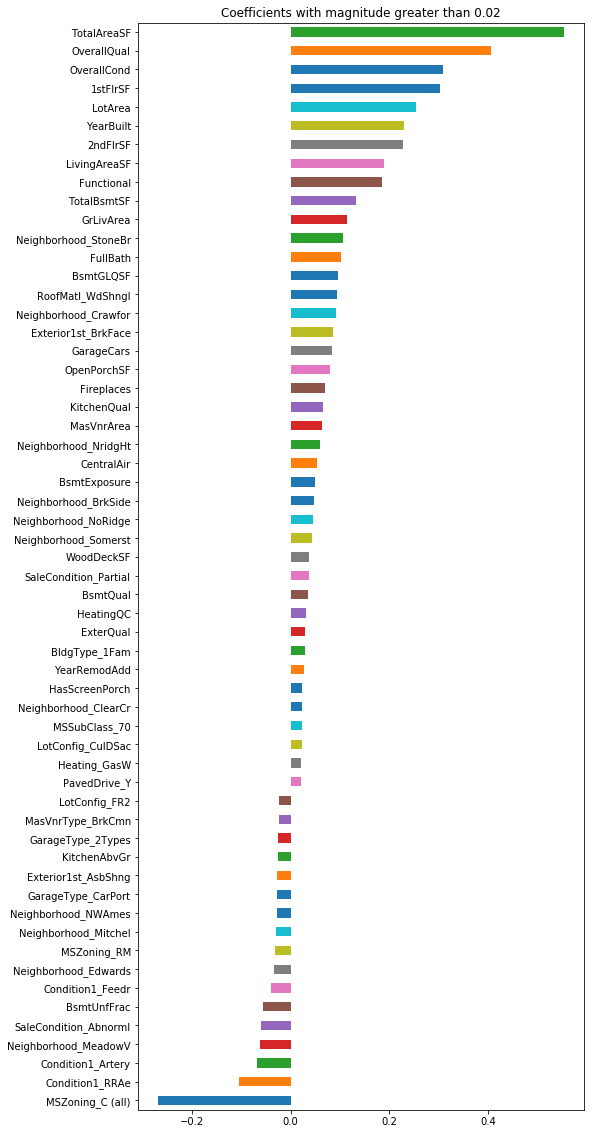

In [47]:
# get coefficients from previously optimised ElasticNet model
en_coefs = pd.Series(opt_models['ElasticNet'].coef_,index=X.columns)

plt.figure(figsize=(8,20))
en_coefs[en_coefs.abs()>0.02].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.02')

print('---------------------------------------')
print(sum(en_coefs==0),'zero coefficients')
print(sum(en_coefs!=0),'non-zero coefficients')
print('---------------------------------------')
print('Intercept: ',opt_models['ElasticNet'].intercept_)
print('---------------------------------------')
print('Top 20 contributers to increased price:')
print('---------------------------------------')
print(en_coefs.sort_values(ascending=False).head(20))
print('---------------------------------------')
print('Top 10 contributers to decreased price:')
print('---------------------------------------')
print(en_coefs.sort_values(ascending=True).head(10))
print('---------------------------------------')
print('Zero coefficients:')
print('---------------------------------------')
print(en_coefs[en_coefs==0].index.sort_values().tolist())

<a id='interactions'></a>
## Find useful interactions

At this point I'm hovering somewhere between 0.117 and 0.118 on the leaderboard. I wanted to try to do a bit better and my attempts at ensemble/stacked models ended up giving worse scores (probbaly something I need to learn about), so I decided to try adding some interaction terms to the model, i.e. one feature multiplied by another. Intuitively it seems like these could be important for determining sale price, a small property finished to a high quality may be worth as much as a larger property that needs a lot of work doing to it, for example.

Including all polynomial terms up to 2nd order ends up giving more than 30,000 features, far more than the number of training examples and unlikely to give good results if we try to fit a model using that. Instead I decided to only include features that meet these criteria:

* Only include interaction terms (e.g. `TotalAreaSF*OverallQual`), exclude squared terms (e.g. `TotalAreaSF*TotalAreaSF`)
* Only include features with non-zero coefficients in the optimised `ElasticNet` model above.
* Only include features with more than 2 unique values, i.e. exclude all binary features and dummy variables.

This reduces the number of features in the new model to around 700. Excluding the dummy variables unfortunately means interactions with categorical variables like `Neighborhood` are not included. I suspect some of these could be important, but to include them in the model an approach other than one-hot encoding should probably be used, so you don't end up with thousands of columns that are ones and zeros multiplied together.

The code below fits a `Lasso` model to the new training data with interactions included, and prints some stats about the resulting coefficients.

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   20.5s finished


----------------------
Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.946416767011
rmse= 0.0897881377885
cross_val: mean= 0.101436937533 , std= 0.00629426206068
------------------------
579 zero coefficients
125 non-zero coefficients
65 non-zero interaction terms.
------------------------
Features with largest coefficients:
------------------------
36                   TotalAreaSF,
26                   OverallCond,
318        Fireplaces, YearBuilt,
21                       LotArea,
9                     Fireplaces,
37                  LivingAreaSF,
453     GarageQual, KitchenAbvGr,
197        BsmtQual, OverallQual,
371        Functional, YearBuilt,
549     KitchenQual, TotalAreaSF,
213        ExterCond, GarageArea,
35                   BsmtUnfFrac,
15                    GarageQual,
280       FireplaceQu, Lan

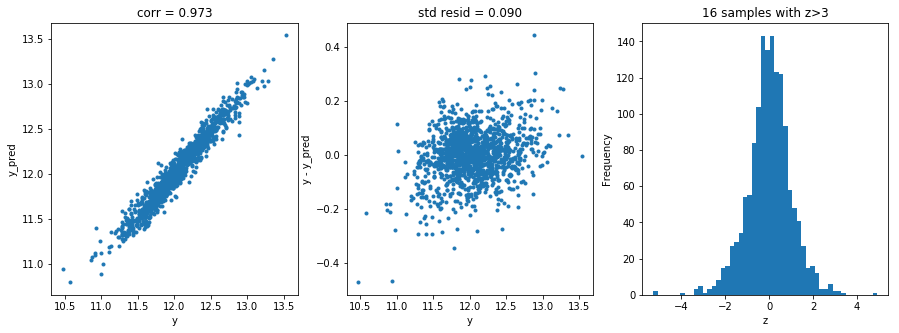

In [48]:
X,y=get_training_data()

#restrict to non-binary columns with non-zero coefficients only
select_cols = [col for col in X.columns if X[col].nunique()>2 and en_coefs[col]!=0]
X = X[select_cols]

# add interaction terms (x1*x2, but not x1**2) for all remaining features
poly = PolynomialFeatures(interaction_only=True)
X_poly = poly.fit_transform(X,y)
X_poly = pd.DataFrame(X_poly,index=y.index)

# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(poly.powers_,columns=X.columns)

s = np.where(powers>0, pd.Series(X.columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])

# fit a new model with the interaction terms
alph_range = np.arange(5e-5,2e-4,2e-5)
param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'max_iter':[100000]}

model,_,_ = train_model(Lasso(), X=X_poly,y=y,param_grid=param_grid, 
                                              splits=splits, repeats=1)

poly_coefs = pd.Series(model.coef_)

print('------------------------')
print(sum(poly_coefs==0),'zero coefficients')
print(sum(poly_coefs!=0),'non-zero coefficients')
print(len(poly_coefs[(powers.sum(axis=1)==2) & (poly_coefs>0)]),'non-zero interaction terms.')
print('------------------------')
print('Features with largest coefficients:')
print('------------------------')
print(poly_terms[poly_coefs.abs().sort_values(ascending=False).index[:30]])
print('------------------------')

## Refit with Important Interactions

Using the model above directly ends up giving a worse cross-validation score, bah! So I had to restrict myself to an even more limited range of interaction terms. 

Above we can see that the number of non-zero coefficients in the new fitted model is actually about the same as before without the interaction terms - the vast majority of the new interactions I added end up being removed from the model. However, more promisingly about half of the non-zero coefficients correspond to interactions, so about 60 of the original features have been replaced in the model by interactions. And 20 out of the 30 largest coefficients are interactions! Some of the interactions that are important make sense, such as `BsmtQual*OverallQual`, or `KitchenQual*TotalAreaSF`. Others maybe not so much, like `Fireplaces*YearBuilt` which is now the 3rd most important feature!

I decided to create a new model including the interactions with the top 20 largest (magnitude) coefficients, irrespective of whether they were interactions that seemed logical to me. The code below adds these interactions to the train and test data, then fits a new `ElasticNet` model.

In [49]:
# sort coefficients by magnitude, and calculate no. features that contribute
# to the polynomial term that coefficient represents.
poly_coef_nterms = powers.loc[poly_coefs.abs().sort_values(ascending=False).index].sum(axis=1)

# extract n_ints top interactions (interactions have 2 non-zero features in the powers vector)
n_ints = 20
top_n_int_idx = poly_coef_nterms[poly_coef_nterms==2].head(n_ints).index

# create a column for each of the top n_ints interactions in df_model
for idx in top_n_int_idx:
    # extract names of columns to multiply
    int_terms = powers.loc[idx]
    int_terms = int_terms[int_terms==1].index    
    term1 = int_terms[0]
    term2 = int_terms[1]
    
    # create interaction column
    df_model[term1+'_x_'+term2] = scale_minmax(df_model[term1]*df_model[term2])

# have a look at the new columns
display(df_model[df_model.columns[df_model.columns.str.contains('_x_')]].head(5))

Fireplaces_x_YearBuilt            ...              GarageArea_x_KitchenAbvGr
Id                                    ...                                       
1                 0.000000            ...                               0.297894
2                 0.213044            ...                               0.253005
3                 0.307529            ...                               0.327952
4                 0.058455            ...                               0.344796
5                 0.303350            ...                               0.438464

[5 rows x 20 columns]

Fitting 25 folds for each of 81 candidates, totalling 2025 fits


[Parallel(n_jobs=1)]: Done 2025 out of 2025 | elapsed:  5.5min finished


----------------------
ElasticNet(alpha=0.00020000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.90000000000000002, max_iter=100000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
score= 0.958704892926
rmse= 0.0788231535031
cross_val: mean= 0.0899758322891 , std= 0.00588934109401
------------------------
138 zero coefficients
131 non-zero coefficients
--------------------------
Interaction Coefficients:
--------------------------
Functional_x_OverallQual      0.291887
BsmtQual_x_TotalBsmtSF        0.228180
1stFlrSF_x_BsmtExposure       0.167969
KitchenQual_x_TotalAreaSF     0.127111
Functional_x_YearBuilt        0.097591
OverallCond_x_BsmtUnfFrac     0.094603
1stFlrSF_x_ExterQual          0.076380
FullBath_x_LotShape           0.065676
BsmtQual_x_OverallQual        0.059302
YearBuilt_x_YrSold            0.049110
FireplaceQu_x_BsmtGLQSF       0.043124
GarageArea_x

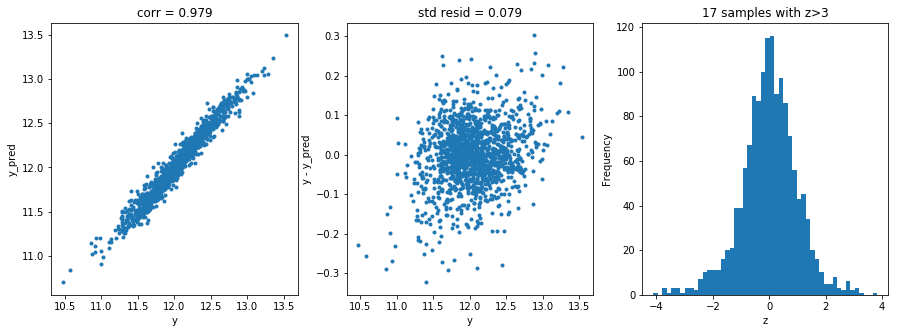

In [50]:
# fit a new model including the added interaction terms
en_int = ElasticNet()
alph_range = np.arange(5e-5,5e-4,2e-5)
param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

en_int, cv_score, grid_results = train_model(en_int, param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

X,y=get_training_data()
en_int_coef = pd.Series(en_int.coef_,index=X.columns)
print('------------------------')
print(sum(en_int_coef==0),'zero coefficients')
print(sum(en_int_coef!=0),'non-zero coefficients')
print('--------------------------')
print('Interaction Coefficients:')
print('--------------------------')
print(en_int_coef[en_int_coef.index.str.contains('_x_')].sort_values(ascending=False))
print('---------------------------------------')
print('Top 10 contributers to increased price:')
print('---------------------------------------')
print(en_int_coef.sort_values(ascending=False).head(10))
print('---------------------------------------')
print('Top 5 contributers to decreased price:')
print('---------------------------------------')
print(en_int_coef.sort_values(ascending=True).head(5))
print('---------------------------------------')

## Predict SalePrice for the Test Data

The `ElasticNet` model including the top 20 interactions gives a better cross-validation score than the original models, and this is the final model I used. 

All that's left is to predict the sale prices for the test data, create the submission file, and submit it to kaggle. The last time I submitted the notebook it gave a score of 0.11571. This varies slightly depending on the random cross-validation folds chosen and so on - the best I achieved was 0.11553.

In [51]:
def predict_test(model):
    # get test data
    X_test = get_test_data()

    # predict SalePrices
    y_test = model.predict(X_test)

    #revert log transformation
    y_test = np.exp(y_test)

    # make a data frame suitable for creating submission files0.11571
    y_test = pd.DataFrame(y_test,index=X_test.index)
    y_test.columns = ['SalePrice']
    
    return y_test

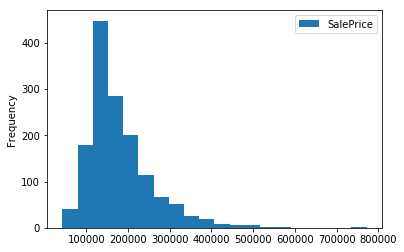

In [52]:
# predict sale prices
y_test = predict_test(en_int)

# make submission file
y_test.to_csv('submission.csv')

# overview of what sale prices were predicted
y_test.plot.hist(bins=20)

## Thanks!

Thanks for reading and I hope this notebook is useful for someone getting started with this dataset, although there are many great kernels already out there. Any questions, comments or suggestions would be much appreciated!